In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 21.2 MB/s 
     |████████████████████████████████| 212 kB 72.6 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)
    

Using TensorFlow version 2.8.2


In [ ]:
dataset = nlp.load_dataset("emotion")

Using custom data configuration default


Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset
import pandas as pd
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val=dataset['validation']
test =  dataset['test']
df = pd.DataFrame(train)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   16000 non-null  object
 1   text    16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [ ]:
df.describe()

,label,text
count,16000,16000
unique,6,15969
top,joy,i feel on the verge of tears from weariness i ...
freq,5362,2


In [ ]:
def get_tweet(data):
  tweets = [X['text'] for X in data]
  labels = [X['label'] for X in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[1], labels[1] 

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

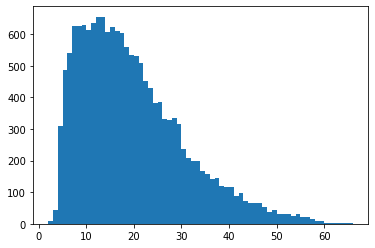

In [ ]:
#length of tweets

lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes = set(labels)
print(classes)

{'anger', 'fear', 'joy', 'surprise', 'love', 'sadness'}


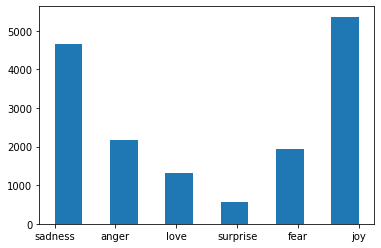

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 4, 'sadness': 5, 'surprise': 3}

In [ ]:
index_to_class

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'surprise', 4: 'love', 5: 'sadness'}

In [ ]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels  = name_to_ids(labels)
print(train_labels[3])

4


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels=name_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [ ]:
history= model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]      
)

Epoch 1/20
500/500 [==============================] - 16s 15ms/step - loss: 1.3213 - accuracy: 0.4741 - val_loss: 0.8138 - val_accuracy: 0.6865
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.5709 - accuracy: 0.7955 - val_loss: 0.5250 - val_accuracy: 0.8255
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2708 - accuracy: 0.9150 - val_loss: 0.4188 - val_accuracy: 0.8720
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1658 - accuracy: 0.9485 - val_loss: 0.4042 - val_accuracy: 0.8770
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1211 - accuracy: 0.9611 - val_loss: 0.3850 - val_accuracy: 0.8850
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1072 - accuracy: 0.9653 - val_loss: 0.3873 - val_accuracy: 0.8880
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0709 - accuracy: 0.9766 - val_loss: 0.4525 - val_accuracy: 0.884

In [ ]:
model.save("tweet_emotion_model.h5")

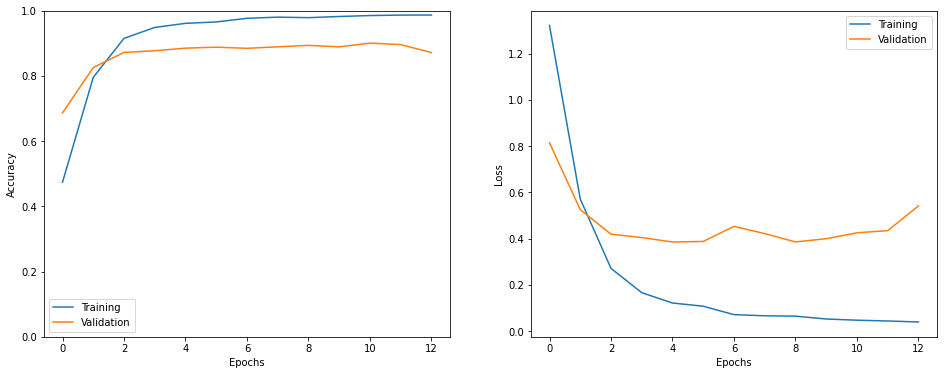

In [ ]:
show_history(history)

In [ ]:
test_tweets,test_labels=get_tweet(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = name_to_ids(test_labels)

In [ ]:
eval = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.5297 - accuracy: 0.8620


In [ ]:
i = random.randint(0, len(test_labels)-1)
print('Sentences: ', test_tweets[i])
print('Emotions: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print ('Pridicted emotion: ',pred_class)

Sentences:  i should pull out if i feel resentful or edgy
Emotions:  anger
Pridicted emotion:  anger


In [ ]:
preds= np.argmax(model.predict(test_seq),axis=1)
#preds = np.rint(preds)
#preds = preds.astype(np.int32)
#preds = preds.flatten()
# pred = tf.convert_to_tensor(preds)
# tf.round(pred)
# preds
# test_labels
# classes

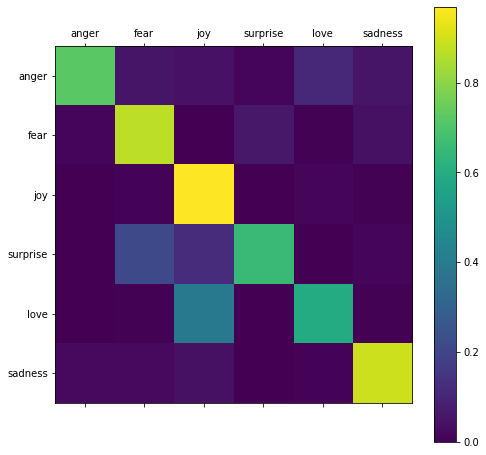

In [ ]:
show_confusion_matrix(test_labels,preds,list(classes))
# from sklearn.metrics import confusion_matrix
# print(confusion_matrix(test_labels,preds))

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(test_labels,preds)

1.2195

In [ ]:
from joblib import dump

In [ ]:
dump(model,'model.joblib')

INFO:tensorflow:Assets written to: ram://af92d81d-03a7-4913-b47c-f55a4318bf10/assets


INFO:tensorflow:Assets written to: ram://af92d81d-03a7-4913-b47c-f55a4318bf10/assets


['model.joblib']